# Simulations of cereal monocrops and intercrops

In [1]:
import math
import time
from random import *
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from itertools import product
from ipywidgets import interact, interactive, IntSlider, fixed

from openalea.mtg.traversal import pre_order2, pre_order2_with_filter
from openalea.plantgl.all import (Color3, Material, Vector3)
nice_green = Color3((50, 100, 0))
from oawidgets.plantgl import *

from alinea.caribu.CaribuScene import CaribuScene
from alinea.caribu.data_samples import data_path

# from archicrop
from openalea.archicrop.cereals import build_shoot
from openalea.archicrop.display import display_mtg, build_scene, display_scene
from openalea.archicrop.stand import regular_plot, agronomic_plot
from openalea.archicrop.dynamic import thermal_time, grow_plant_from_constraint
from openalea.archicrop.grow_from_constraint import read_columns_from_file, distribute_constraint_among_plants
from openalea.archicrop.light_it import compute_light_inter

# Enable plotting with PlantGL
%gui qt

## Generate potential plants from architectural parameters

In [2]:
def dict_ranges_to_all_possible_combinations(d):
    # Convert single floats to lists for consistency
    values = [
        v if isinstance(v, list) else [v]
        for v in d.values()
    ]
    
    # Generate all combinations
    parameters_combinations = list(product(*values))
    return parameters_combinations

In [3]:
# For sorghum
archi_parameters_ranges = {
    "nb_phy": 26, 
    "height": 223,
    "max_leaf_length": 100,
    "wl": 0.12, 
    "diam_base": 2.5, 
    "diam_top": 1.5, 
    "insertion_angle": [10, 30, 50], # Truong et al., 2015
    "scurv": 0.6, 
    "curvature": [45, 90, 135], 
    "alpha": -2.3, 
    "stem_q": 1, 
    "rmax": 0.67, 
    "skew":0.05, # 0.0005
    "phyllotactic_angle": 180, # preprint Davis et al., 2024
    "phyllotactic_deviation": [5, 45]
}

archi_parameters_combinations = dict_ranges_to_all_possible_combinations(archi_parameters_ranges)
print(len(archi_parameters_combinations))

# Print combinations in the original order of dictionary keys
for combo in archi_parameters_combinations:
    print(combo)

# archi_parameters in archi_parameters_combinations

18
(26, 223, 100, 0.12, 2.5, 1.5, 10, 0.6, 45, -2.3, 1, 0.67, 0.05, 180, 5)
(26, 223, 100, 0.12, 2.5, 1.5, 10, 0.6, 45, -2.3, 1, 0.67, 0.05, 180, 45)
(26, 223, 100, 0.12, 2.5, 1.5, 10, 0.6, 90, -2.3, 1, 0.67, 0.05, 180, 5)
(26, 223, 100, 0.12, 2.5, 1.5, 10, 0.6, 90, -2.3, 1, 0.67, 0.05, 180, 45)
(26, 223, 100, 0.12, 2.5, 1.5, 10, 0.6, 135, -2.3, 1, 0.67, 0.05, 180, 5)
(26, 223, 100, 0.12, 2.5, 1.5, 10, 0.6, 135, -2.3, 1, 0.67, 0.05, 180, 45)
(26, 223, 100, 0.12, 2.5, 1.5, 30, 0.6, 45, -2.3, 1, 0.67, 0.05, 180, 5)
(26, 223, 100, 0.12, 2.5, 1.5, 30, 0.6, 45, -2.3, 1, 0.67, 0.05, 180, 45)
(26, 223, 100, 0.12, 2.5, 1.5, 30, 0.6, 90, -2.3, 1, 0.67, 0.05, 180, 5)
(26, 223, 100, 0.12, 2.5, 1.5, 30, 0.6, 90, -2.3, 1, 0.67, 0.05, 180, 45)
(26, 223, 100, 0.12, 2.5, 1.5, 30, 0.6, 135, -2.3, 1, 0.67, 0.05, 180, 5)
(26, 223, 100, 0.12, 2.5, 1.5, 30, 0.6, 135, -2.3, 1, 0.67, 0.05, 180, 45)
(26, 223, 100, 0.12, 2.5, 1.5, 50, 0.6, 45, -2.3, 1, 0.67, 0.05, 180, 5)
(26, 223, 100, 0.12, 2.5, 1.5, 50, 0.6

In [4]:
def generate_potential_plant(archi_parameters):
    shoot, potential_plant = build_shoot(*archi_parameters)
    return potential_plant

## Make the plant grow according to leaf area and height constraints from crop model

### Retrieve STICS output data

In [5]:
## From a STICS simulation for sorghum
filename = 'mod_ssorghum.sti'
columns = read_columns_from_file(filename)
columns = columns[5:]

start = 21 #21
end = 90
density = 10 # density = 20 plants/m2 = 0.002 plants/cm2

tt_cum = list(np.cumsum([float(i) for i in columns[0][start:end-1]]))
# print(list(tt_cum))

la_cum = [1000*float(i)/density for i in columns[1][start:end]] # from m2/m2 to cm2/plant
la_incr = [la_cum[i+1]-la_cum[i] for i in range(len(la_cum[1:]))]
# print(la_incr)

height_cum = [float(i) for i in columns[2][start:end]]
height_incr = [height_cum[i+1]-height_cum[i] for i in range(len(height_cum[1:]))]
# print(height_incr)

par = [float(i) for i in columns[3][start:end]] 
print(len(par)) # in MJ/m^2

constraints_crop = [height_incr, la_incr]

69


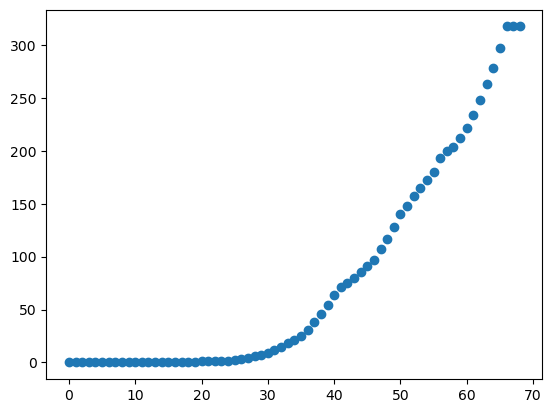

In [6]:
plt.scatter(range(len(la_cum)), la_cum)
plt.show()

### Set crop parameters according to those in STICS simulations

In [7]:
def dict_ranges_to_possible_combinations_paired(d):
    
    parameters_combinations = dict_ranges_to_all_possible_combinations(d)

    # Filter combinations where sowing_density == plant_density
    filtered_combinations = [
        combo for combo in parameters_combinations
        if combo[2] == combo[3]  # Ensure sowing_density == plant_density
    ]
    
    return filtered_combinations

In [8]:
crop_parameters_ranges = {
    "length_plot": 1, 
    "width_plot": 1, 
    "sowing_density": [10, 28], 
    "plant_density": [10, 28], 
    "inter_row": 0.4, # 0.4 for 10
}


crop_parameters_combinations = dict_ranges_to_possible_combinations_paired(crop_parameters_ranges)

# Print the number of combinations
print(len(crop_parameters_combinations))

# Print combinations in the original order of dictionary keys
for combo in crop_parameters_combinations:
    print(combo)

# crop_parameters in crop_parameters_combinations

2
(1, 1, 10, 10, 0.4)
(1, 1, 28, 28, 0.4)


### Grow plants in monocrop and compute light interception at all time steps

In [9]:
def algo(archi_parameters, constraints_crop, crop_parameters, tt_cum):

    # Fix a seed
    seed(100)

    # Spatial arrangement parameters
    nb_of_plants, positions, domain, domain_area, unit = agronomic_plot(*crop_parameters, noise=0.1)

    # Generate potential plant of monocrop
    potential_plant = generate_potential_plant(archi_parameters)
    potential_plant = thermal_time(potential_plant)

    # Loop through time
    par_caribu = []
    for i, tt in enumerate(tt_cum):
        constraints_crop_tt = [constraints_crop[0][i], constraints_crop[1][i]]
        constraints_plants = distribute_constraint_among_plants(constraints_crop_tt, nb_of_plants)
        growing_plant = grow_plant_from_constraint(potential_plant, tt, constraints_plants)
        plants = [growing_plant] * nb_of_plants
        if i > 0:
            # stand
            scene, nump = build_scene(plants, positions, leaf_material=Material(nice_green), stem_material=Material(nice_green))
            # compute light inter
            values = compute_light_inter(scene)
            par_crop = sum(values)*0.0145
            # print(par_crop)
            par_caribu.append(par_crop)
        
    return par_caribu

In [86]:
archis = []
nb_of_plants, positions, domain, domain_area, unit = agronomic_plot(*crop_parameters_combinations[0], noise=0.1)

for archi in archi_parameters_combinations:
    # Generate potential plant of monocrop
    potential_plant = generate_potential_plant(archi)
    potential_plant = thermal_time(potential_plant)

    # Loop through time
    plant = []
    for i, tt in enumerate(tt_cum):
        constraints_crop_tt = [constraints_crop[0][i], constraints_crop[1][i]]
        constraints_plants = distribute_constraint_among_plants(constraints_crop_tt, nb_of_plants)
        growing_plant = grow_plant_from_constraint(potential_plant, tt, constraints_plants)
        plant.append(growing_plant)
    archis.append(plant)

In [13]:
par_test = algo(archi_parameters_combinations[10], constraints_crop, crop_parameters_combinations[0], tt_cum)
par_test2 = 

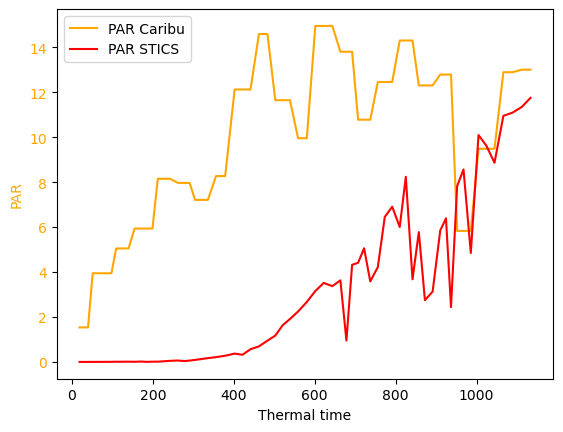

In [25]:
# Sample data
x = tt_cum[1:]
y1 = par_test  
# y2 = la_cum[1:-1]  
y3 = par[1:-1]

# Create the plot
fig, ax1 = plt.subplots()

# Plot the first dataset on the primary y-axis
ax1.plot(x, y1, '-', color='orange', label='PAR Caribu')
ax1.plot(x, y3, '-', color='red', label='PAR STICS')
ax1.set_xlabel('Thermal time')
ax1.set_ylabel('PAR', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

# Create a secondary y-axis
# ax2 = ax1.twinx()
# ax2.plot(x, y2, 'g--', label='LAI')
# ax2.set_ylabel('LAI', color='g')
# ax2.tick_params(axis='y', labelcolor='g')

# Add legends for both axes
ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')

# Show the plot
plt.show()

In [96]:
# display_in_NB(archis[0][2], tt_cum[0])
plants = [archis[11][2]] * nb_of_plants
scene, nump = build_scene(plants, positions, leaf_material=Material(nice_green), stem_material=Material(nice_green))
PlantGL(scene)

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

In [33]:
par_caribu_dens_10 = []
for archi in archi_parameters_combinations:
    par_caribu = algo(archi, constraints_crop, crop_parameters_combinations[0], tt_cum)
    par_caribu_dens_10.append(par_caribu)

In [56]:
par_caribu_dens_20 = []
for archi in archi_parameters_combinations:
    par_caribu = algo(archi, constraints_crop, crop_parameters_combinations[1], tt_cum)
    par_caribu_dens_20.append(par_caribu)

ValueError: Sample larger than population or is negative

In [1]:
# Convert to a NumPy array for easier manipulation
curves = par_caribu_dens_10
curves_array = np.array(curves)

# Calculate the envelope: min and max values for each time point
min_values = curves_array.min(axis=0)
max_values = curves_array.max(axis=0)

# Plotting the envelope along with individual curves for context
time_points = tt_cum[1:]
for curve in curves:
    plt.plot(time_points, curve, alpha=0.5, linestyle='--')  # Plot each curve (optional for visualization)

plt.fill_between(time_points, min_values, max_values, color="skyblue", alpha=0.4)
plt.plot(time_points, min_values, color="blue", linestyle="--", label="Min 3D")
plt.plot(time_points, max_values, color="red", linestyle="--", label="Max 3D")
plt.plot(time_points, par[2:], color="black", label="STICS")
plt.scatter(range(len(la_cum)), la_cum)

# Labels and legend
plt.xlabel("Thermal time")
plt.ylabel("PAR intercepted")
plt.title("PAR intercepted: 3D canopy vs. STICS")
plt.legend()
plt.show()

NameError: name 'par_caribu_dens_10' is not defined